# CDDP Tutorial - Cartpole

This notebook shows how to use the CDDP algorithm to solve the cartpole problem.
© Tomohiro Sasaki, 2023

In [ ]:
import Pkg 
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [6]:
using Plots; gr()
using LinearAlgebra
using BenchmarkTools
using Printf
using Revise
using CDDP

In [7]:
includet("../src/models/cartpole.jl")
model = CartPole()
x_dim, u_dim = model.x_dim, model.u_dim

tf = model.tf
tN = model.tN
dt = model.dt

x_init = model.x_init
x_final = model.x_final
;

In [8]:
function ell_cost(
    x::Vector,
    u::Vector,
    x_ref::Vector{Float64};
)
    
    # Q = 1.0e-2*Diagonal(ones(x_dim))
    Q = zeros(x_dim, x_dim)
    R = 1.0e-1*Diagonal(ones(u_dim))
    return  0.5 * transpose(x - x_ref) * Q * (x - x_ref) + 0.5 * transpose(u) * R * u
end

function phi_cost(
    x::Vector,
    x_final::Vector{Float64};
)
    Qf = 1.0e+2*Diagonal(ones(x_dim))
    return 0.5 * transpose(x - x_final) * Qf * (x - x_final)
end
;

## initial trajectory

In [9]:
using DataInterpolations

X0, U0 = initialize_trajectory(model);

# U0 = 0.02 * randn(tN, u_dim) .- 0.01
# # U0 = zeros(tN, u_dim)
# U0 = Vector[U0[t, :] for t in axes(U0,1)]
# # convert U array into U_func as a continuous function
# U0 = linear_interpolation((collect(LinRange(0.0, tf, tN)),), U0, extrapolation_bc = Line())

# X0 = simulate_trajectory(model, x_init, U0, tf, dt)

# X_ref = Vector[x_final for t in 1:tN+1]
# X_ref =  CubicSpline(X_ref, 0:dt:tf)
X_ref = simulate_trajectory(model, x_final, U0, tf, dt)
;

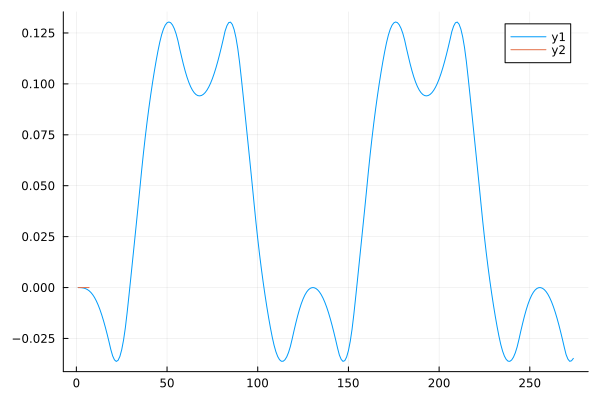

In [10]:
plot(X0[1,:])
plot!(X_ref[1,:])

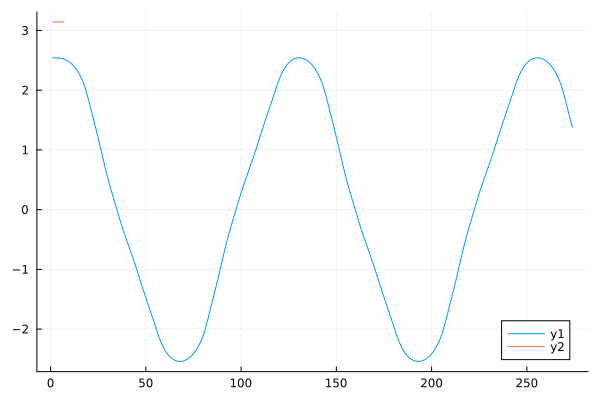

In [11]:
plot(X0[2,:])
plot!(X_ref[2,:])

## iLQR solver

In [24]:
includet("../src/models/cartpole.jl")
model = CartPole()
tf = 5.
tN = 100
dt = tf/tN

x_init = [0; pi-0.6; 0; 0]
prob = iLQRProblem(
    model, 
    tf, 
    tN, 
    dt, 
    x_dim, 
    u_dim, 
    ell_cost, 
    phi_cost, 
    model.f!, 
    empty, 
    x_init, 
    x_final, 
    nothing)
sol = solve_ilqr(
    prob, 
    X=nothing, 
    U=nothing, 
    max_ite=5, 
    tol=1e-8,
    reg_param_x=0e-20, 
    reg_param_x_fact=10.0, 
    reg_param_u=0e-20, 
    reg_param_u_fact=10.0,
    line_search_steps = [0.1])

X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start iLQR Problem Solver 
**************************************************************************************
iter    objective 
                
0       2155.148880,  
                


MethodError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{CDDP.var"#159#163"{iLQRProblem, Vector{Float64}, Float64}, Float64}, Float64, 4})

Closest candidates are:
  (::Type{T})(::Real, !Matched::RoundingMode) where T<:AbstractFloat
   @ Base rounding.jl:207
  (::Type{T})(::T) where T<:Number
   @ Core boot.jl:792
  (::Type{T})(!Matched::VectorizationBase.Double{T}) where T<:Union{Float16, Float32, Float64, VectorizationBase.Vec{<:Any, <:Union{Float16, Float32, Float64}}, VectorizationBase.VecUnroll{var"#s45", var"#s44", var"#s43", V} where {var"#s45", var"#s44", var"#s43"<:Union{Float16, Float32, Float64}, V<:Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit, VectorizationBase.AbstractSIMD{var"#s44", var"#s43"}}}}
   @ VectorizationBase ~/.julia/packages/VectorizationBase/0dXyA/src/special/double.jl:111
  ...


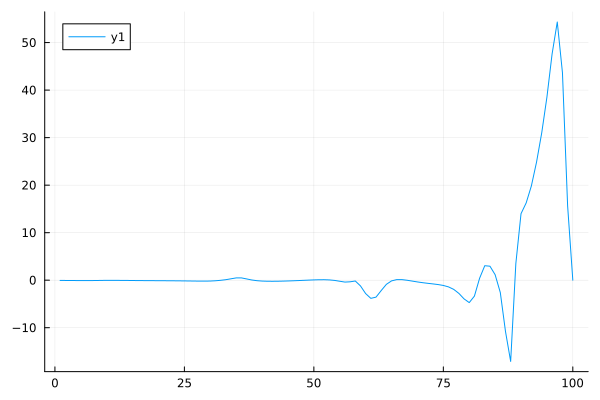

In [17]:
l_arr = zeros(tN)
for k in 1:tN 
    l_arr[k] = gains.l(k*dt)[1]
end
plot(l_arr)

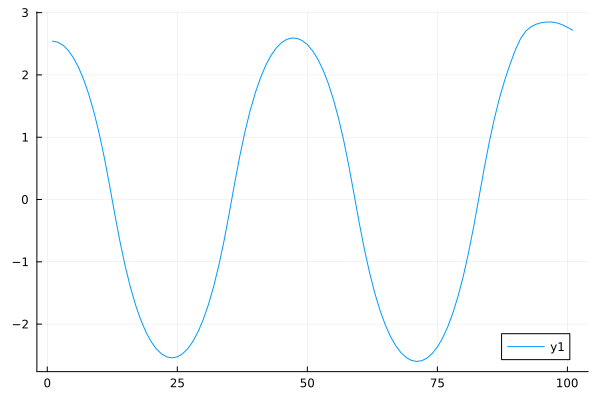

In [18]:
X_arr = Array{Float64, 2}(undef, x_dim, tN+1)
x_new = x_init
X_arr[:,1] = x_new
for k in 1:tN 
    u_new = U((k-1)*dt)
    p = ODEParams(prob.model, u_new, isarray=true)

    # x_new += euler_step(prob.f!, x_new, p, (k-1)*dt, h=dt) * dt
    x_new += rk4_step(prob.f!, x_new, p, (k-1)*dt, h=dt) * dt
    X_arr[:,k+1] = x_new
end
plot(X_arr[2,:])

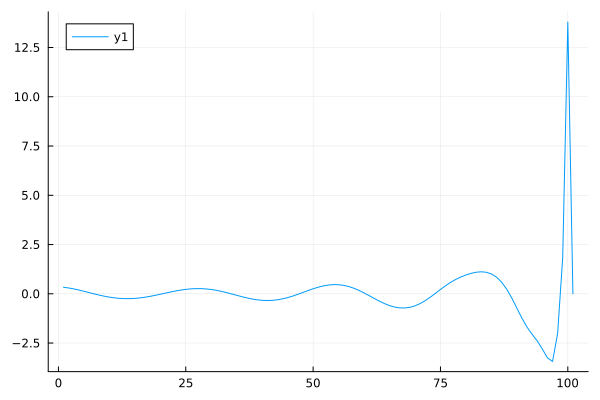

In [316]:
U_arr = zeros(tN+1, u_dim)
for k in 0:tN
    t = k*dt
    U_arr[k+1,:] = U(t)
end
plot(U_arr)

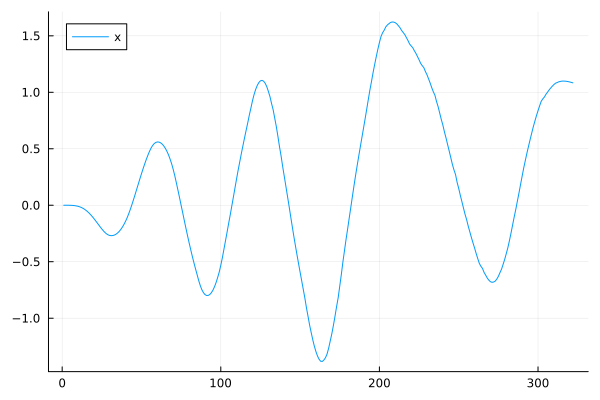

In [298]:
X_arr_ = Array{Float64, 2}(undef, x_dim, tN+1)
x_new = x_init
# X_arr_[:,1] = x_new
for k in 0:tN 
    X_arr_[:,k+1] = X_ilqr(k*dt)
end
plot(X_ilqr[2,:], label="x")


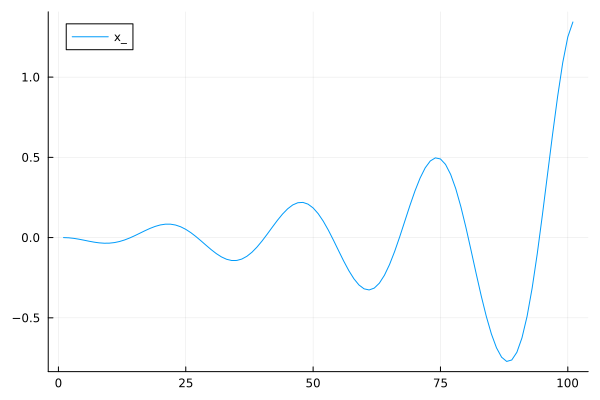

In [252]:
plot(X_arr_[2,:], label="x_")

┌ Info: Saved animation to /Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/results/cartpole.gif
└ @ Plots /Users/astomodynamics/.julia/packages/Plots/esM5q/src/animation.jl:156


Plots.AnimatedGif("/Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/results/cartpole.gif")
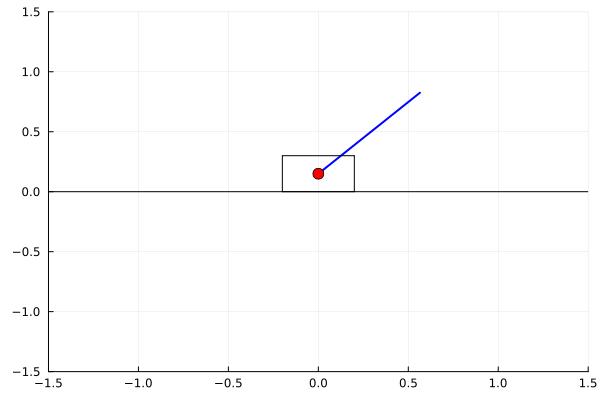

In [8]:
function make_gif(X)
    

    anime = Animation()
    for k in 0:tN
        x = X(k*dt)
        xc = x[1]
        θ = x[2]
        xx = sin(θ)
        xy = -cos(θ)
        r_cart = [xc, 0.15]
        plt = plot([r_cart[1], xx], [r_cart[2], xy], label="",xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), color=:blue, linewidth=2, equal_aspect=true)
        scatter!((r_cart[1],r_cart[2]), color=:red, markersize=6, legend=false, marker=:circle, fillcolor=nothing)
        
        # horizontal line
        plot!([-1.5, 1.5], [0., 0.], label="", color=:black, linewidth=1)
        
        # right wall
        plot!([r_cart[1]+0.2, r_cart[1]+0.2], [0., 0.3], label="", color=:black, linewidth=1)
        # left wall
        plot!([r_cart[1]-0.2, r_cart[1]-0.2], [0., 0.3], label="", color=:black, linewidth=1)
        # top wall
        plot!([r_cart[1]-0.2, r_cart[1]+0.2], [0.3, 0.3], label="", color=:black, linewidth=1)
        # bottom wall
        plot!([r_cart[1]-0.2, r_cart[1]+0.2], [0., 0.], label="", color=:black, linewidth=1)

        frame(anime, plt)
    end

    gif(anime, "../results/cartpole.gif", fps = 15)
end

make_gif(X0)

In [194]:
using DataInterpolations, Plots
gr()
# Dependent variable
u = [14.7, 11.51, 10.41, 14.95, 12.24, 11.22]
# Independent variable
t = [0.0, 62.25, 109.66, 162.66, 205.8, 252.3]
A = CubicSpline(u,t)

12-element CubicSpline{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, true, Float64}:
  14.7
  11.51
  10.41
  14.95
  12.24
  11.22
   0.0
  62.25
 109.66
 162.66
 205.8
 252.3

In [275]:
t = 0:0.01:2*pi
s = sin.(t)
c = cos.(t)
u = s
u = Vector[[sin(k),cos(k)] for k in t]
# uu::Vector{Matrix{Float64}} = [[cos(k) -sin(k); sin(k) cos(k)] for k in t]
# A = CubicSpline(uu,t)
A = BSplineInterpolation(u,t,3, :ArcLen,:Average)
# plot(t, A.(t), label="Cubic Spline")

MethodError: MethodError: no method matching zero(::Type{Vector{Float64}})

Closest candidates are:
  zero(!Matched::Union{Type{P}, P}) where P<:Dates.Period
   @ Dates /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/Dates/src/periods.jl:51
  zero(!Matched::G) where G<:Graphs.AbstractGraph
   @ Graphs ~/.julia/packages/Graphs/7SMZs/src/interface.jl:340
  zero(!Matched::FillArrays.Ones{T, N}) where {T, N}
   @ FillArrays ~/.julia/packages/FillArrays/KpKaA/src/FillArrays.jl:527
  ...


In [217]:
A(2*pi+0.5)

2×2 Matrix{Float64}:
 5.75982   -0.447323
 0.447323   5.75982

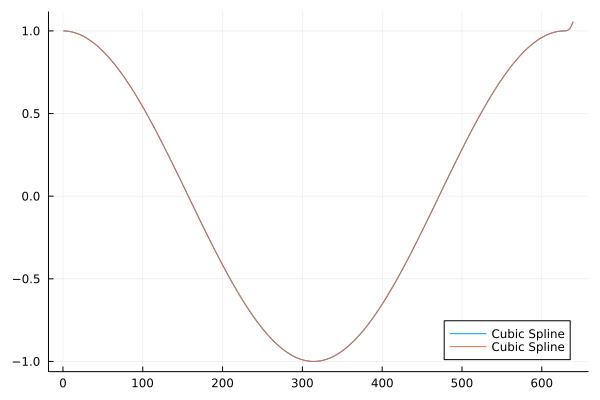

In [222]:
A_mat = zeros(2,2,length(t)+10)
for k in 1:length(t)+10
    A_mat[:,:,k] = A(k*0.01)
end

plot(A_mat[1,1,:], label="Cubic Spline")
plot!(A_mat[2,2,:], label="Cubic Spline")